# GENDER detection 


In [1]:
# Import necessary modules first.
import tensorflow as tf
from tensorflow.keras.utils import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
import numpy as np
import random
import matplotlib.pyplot as plt
import os 
import seaborn as sns
import warnings 
from tqdm.notebook import tqdm 
warnings.filterwarnings('ignore')
%matplotlib inline

## Loading the dataset: 
https://www.kaggle.com/datasets/jangedoo/utkface-new


In [2]:
directory_path = 'D:/SpaceScan/SSVIP-Data-Science-GenderDetection/Dataset'

# List all the files in the directory
file_list = os.listdir(directory_path)

In [3]:
BASE_DIR = 'D:/SpaceScan/SSVIP-Data-Science-GenderDetection/Dataset/UTKFace'
age_labels = []
gender_labels = []
image_paths = []

image_filenames = os.listdir(BASE_DIR)
random.shuffle(image_filenames)

for image in tqdm(image_filenames):
  image_path = os.path.join(BASE_DIR, image)
  img_components = image.split('_')
  age_label = int(img_components[0])
  gender_label = int(img_components[1])

  # Append the image_path, age_label, and gender_label
  age_labels.append(age_label)
  gender_labels.append(gender_label)
  image_paths.append(image_path)

  0%|          | 0/23708 [00:00<?, ?it/s]

This code reads image file names from a directory, extracts age and gender information from the file names, and stores this information in three lists: image_paths for the file paths, age_labels for the age information, and gender_labels for the gender information. This is typically done as a preprocessing step when working with image datasets for tasks like age and gender detection.

In [4]:
print(f'Number of age_labels: {len(age_labels)}, Number of gender_labels: {len(gender_labels)}, Number of image_paths: {len(image_paths)}')

Number of age_labels: 23708, Number of gender_labels: 23708, Number of image_paths: 23708


In [5]:
gender_mapping = {
    1: 'Female',
    0: 'Male'
}

In [6]:
import pandas as pd 
df = pd.DataFrame()
df['image_path'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head(5)

,image_path,age,gender
0,D:/SpaceScan/SSVIP-Data-Science-GenderDetectio...,33,1
1,D:/SpaceScan/SSVIP-Data-Science-GenderDetectio...,35,0
2,D:/SpaceScan/SSVIP-Data-Science-GenderDetectio...,10,0
3,D:/SpaceScan/SSVIP-Data-Science-GenderDetectio...,3,0
4,D:/SpaceScan/SSVIP-Data-Science-GenderDetectio...,29,0


## using the Python Imaging Library (PIL) to open and display an image from the dataset. 


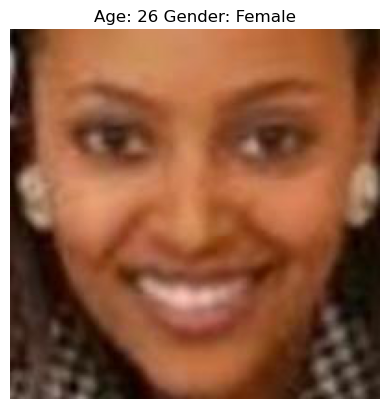

In [7]:
from PIL import Image

rand_index = random.randint(0, len(image_paths))
age = df['age'][rand_index]
gender = df['gender'][rand_index]
IMG = Image.open(df['image_path'][rand_index])
plt.title(f'Age: {age} Gender: {gender_mapping[gender]}')
plt.axis('off')
plt.imshow(IMG)


<Axes: ylabel='count'>

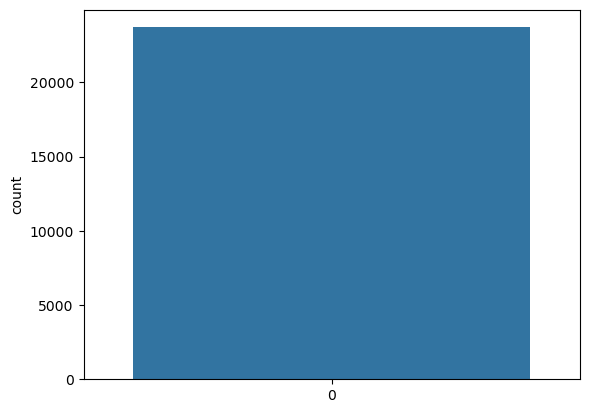

In [8]:
sns.countplot(df['gender'])

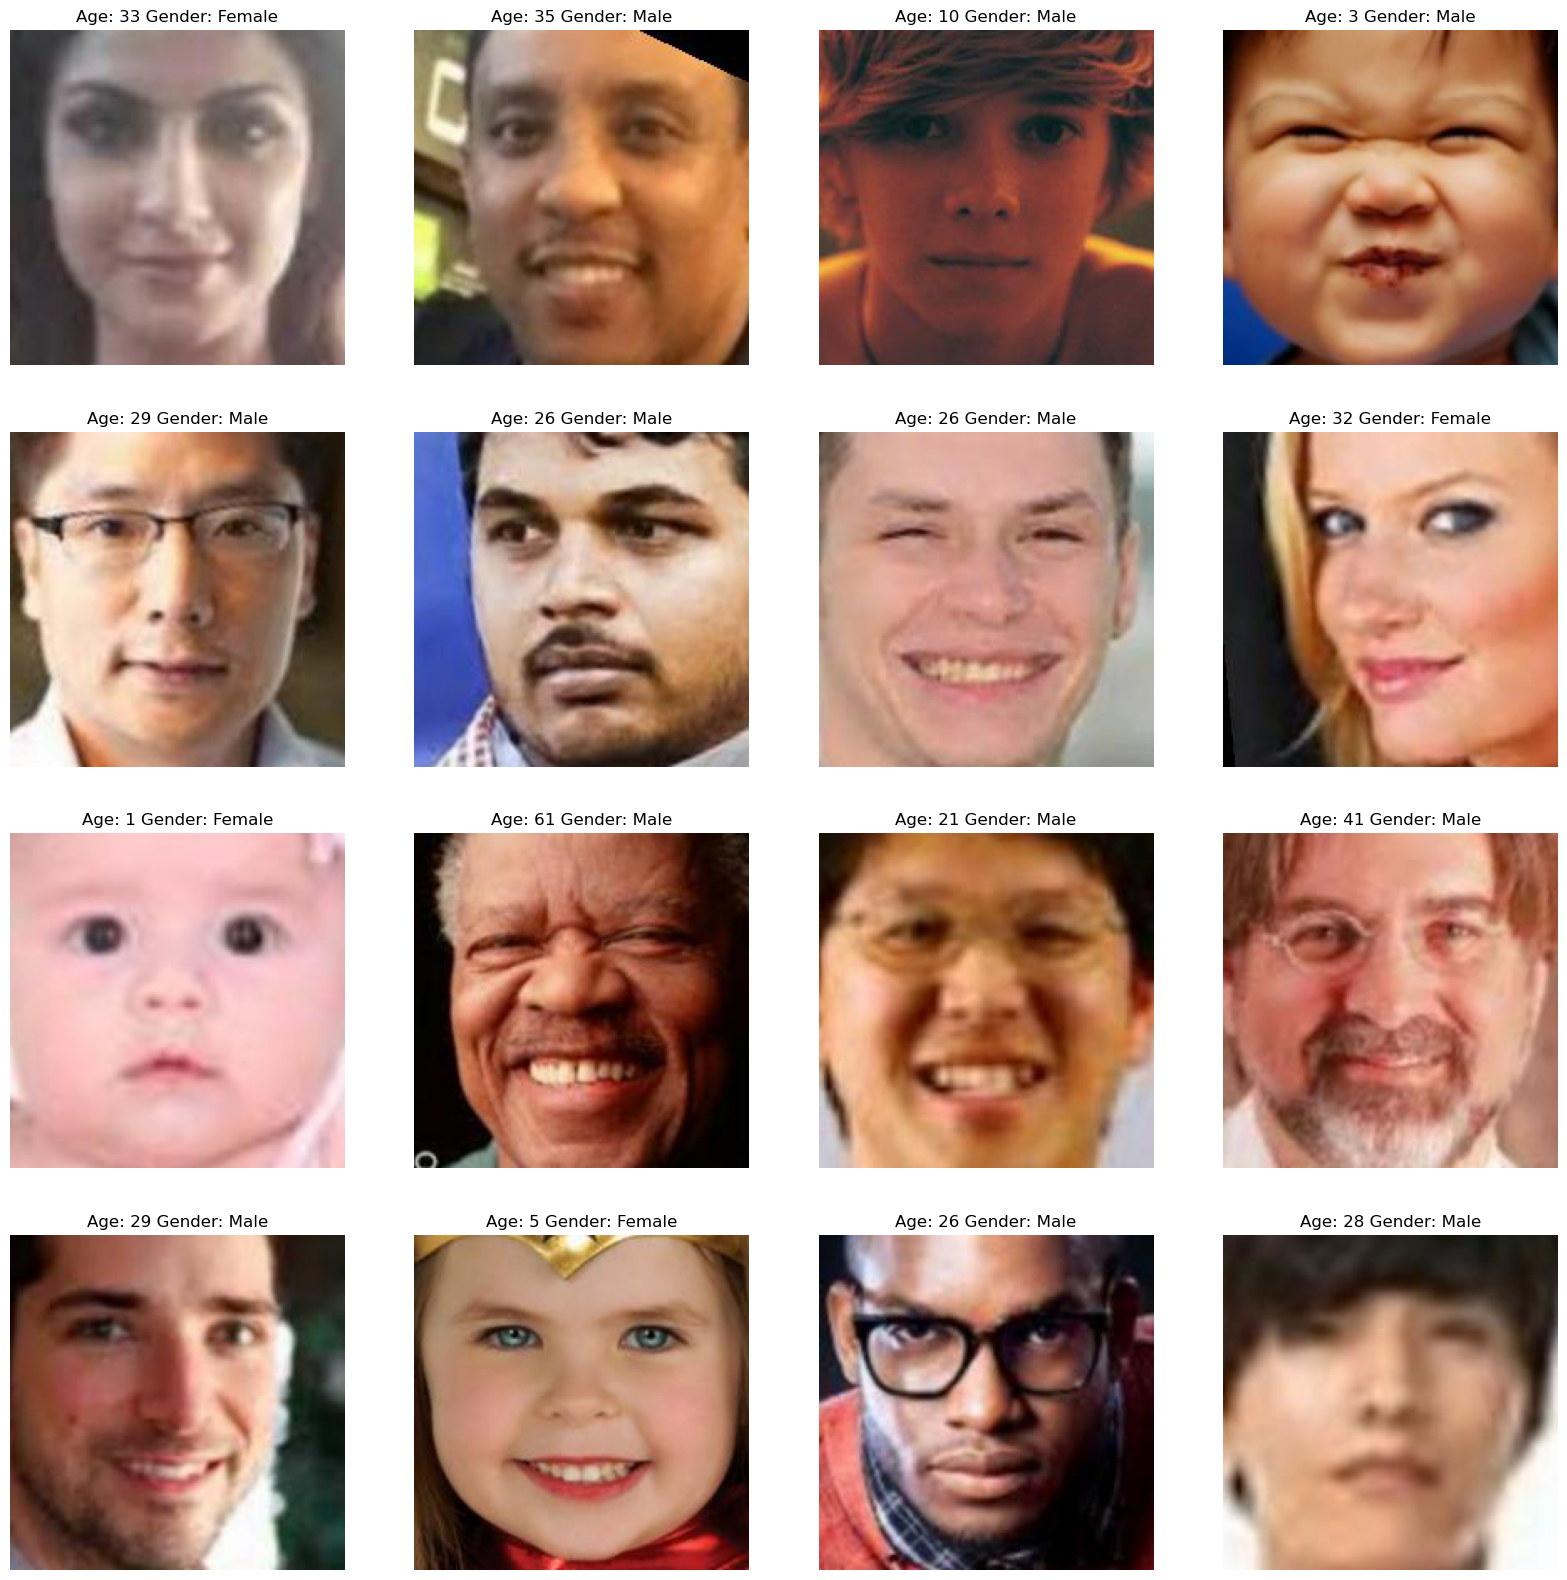

In [9]:


plt.figure(figsize=(20, 20))
samples = df.iloc[0:16]

for index, sample, age, gender in samples.itertuples():
    plt.subplot(4, 4, index + 1)
    img = load_img(sample)
    img = np.array(img)
    plt.axis('off')
    plt.title(f'Age: {age} Gender: {gender_mapping[gender]}')
    plt.imshow(img)





In [10]:
def extract_image_features(images):
    features = list()

    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features


In [11]:
X = extract_image_features(df['image_path'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [12]:
X.shape

(23708, 128, 128, 1)

In [13]:
X = X / 255.0

In [14]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [15]:
input_shape = (128, 128, 1)

In [16]:
## using the Keras library for a multi-output problem. 
inputs = Input((input_shape))
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
max_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(max_1)
max_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(max_2)
max_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(max_3)
max_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)

flatten = Flatten()(max_4)

# fully connected layers
dense_1 = Dense(256, activation='relu')(flatten)
dense_2 = Dense(256, activation='relu')(flatten)

dropout_1 = Dropout(0.3)(dense_1)
dropout_2 = Dropout(0.3)(dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out')(dropout_1)
output_2 = Dense(1, activation='relu', name='age_out')(dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'],
              optimizer='adam', metrics=['accuracy'])

history = model.fit(x=X, y=[y_gender, y_age],
                    batch_size=32, epochs=50, validation_split=0.2)

## Predicting the result of given image

In [18]:
def get_image_features(image):
  img = load_img(image, grayscale=True)
  img = img.resize((128, 128), Image.ANTIALIAS)
  img = np.array(img)
  img = img.reshape(1, 128, 128, 1)
  img = img / 255.0
  return img

1/1 [==============================] - 0s 47ms/step


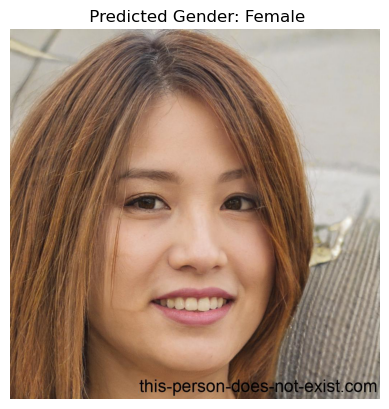

In [23]:
img_to_test = 'D:/SpaceScan/SSVIP-Data-Science-GenderDetection/faces/girl.jpg'
features = get_image_features(img_to_test)
pred = model.predict(features)
gender = gender_mapping[round(pred[0][0][0])]

plt.title(f' Predicted Gender: {gender}')
plt.axis('off')
plt.imshow(np.array(load_img(img_to_test)))